# Social Reward Modeling

We will define a generative model, where the learning rate will be fixed instead of estimated from participants' data. Value and prediction error signals from this model will be explored in the brain. 

## Set Up

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("future.no_silent_downcasting", True)


### Set Paths

In [2]:
proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'
data_dir = os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data')
outp_dir = os.path.join(proj_dir, 'derivatives', 'rl_modeling', 'event_files')

os.chdir(proj_dir)

### Find Participants

In [3]:
# Import participant id data
subj_df = pd.read_csv(proj_dir+'participants.tsv', sep='\t')

# Fix participant IDs to match the directories in the data folder (e.g. sub-SCN101 -> SCN_101)
subj_df['participant_id'] = [x[4:7]+'_'+x[7:] for x in subj_df['participant_id']]

# Create subject list
subj_list = subj_df['participant_id'].unique()


print('Found '+str(len(subj_list))+' participants')

Found 133 participants


## Model Designs

### Model 1: Rescorla Wagner

This model takes as input a trial list, which contains information about the conditions (similar, dissimilar, or computer), and feedback (thumbs up or down) for each trial, and returns the following outputs: expected value of the three conditinos on each trial, and reward prediction error. 

In [362]:
def rw_model(trial_list, alpha, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))

    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    
    for t in range(len(trial_list)):
        # Capture trial info
        cond_t = trial_list.loc[t, 'Peer']
        value_t = V.loc[t, cond_t]
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['RPE'] = RPE
    
    return RL_output

### Model 2: Rescorla Wagner + Random RT
This will serve as the null model

In [363]:
def rw_randrt_model(trial_list, alpha, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))

    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5    
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))

    # Define minimum and maxium reaction time for random sampling
    min_rt = 0.25
    max_rt = 2.0
    
    for t in range(len(trial_list)):
        # Capture trial info
        cond_t = trial_list.loc[t, 'Peer']

        # Create a random RT
        RT[t] = np.random.uniform(min_rt,max_rt)

        # Calculate the current value
        value_t = V.loc[t, cond_t] + np.log(RT[t])

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t
        
        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model 3: Rescorla Wagner + RT Value
- https://pmc.ncbi.nlm.nih.gov/articles/PMC8930195/
    - RTt = -B|Vpst - Vpdt - Vct| + error
        - B = 1
        - Vpst = value of peer similar at t
        - Vpdt = value of peer dissimilar at t
        - Vct = value of computer at t
        - error = Gaussian random noise, with mean = 1 and SD = 5 * SD of |Vpst - Vpdt - Vct|

In [364]:
def rw_rtvalue_model(trial_list, alpha, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))
    
    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))

    # Set model parameters
    B = -1
    mu = 0
    
    for t in range(len(trial_list)):
        # Capture the trial info
        cond_t = trial_list.loc[t, 'Peer']

        # Create a RT based on the value of each condition
        cond_diff = np.abs(V.loc[t, 'SimPeer'] - V.loc[t, 'DisPeer'] - V.loc[t, 'Computer'])
        sigma = np.std(V['SimPeer'] - V['DisPeer'] - V['Computer'])
        RT[t] = np.abs(np.abs(cond_diff) + np.random.normal(mu, 0.05))
        #RT[t] = np.abs(np.random.uniform(0.25,2) - V.loc[t, cond_t])

        # Calculate the current value
        value_t = V.loc[t, cond_t] + np.log(RT[t])

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model 4: RW + Negative Reward

### Model 5: RW + Random RT + Negative Reward

### Model 6: RW + RT Value + Negative Reward

### Model 7: RW + Item Value

In [366]:
def rw_item_model(trial_list, alpha, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))

    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    
    for t in range(len(trial_list)):
        # Capture trial info
        cond_t = trial_list.loc[t, 'Peer']
        value_t = V.loc[t, cond_t]
        feedback_t = trial_list.loc[t, 'Feedback']
        item_v_t = trial_list.loc[t, 'Interest']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t * item_v_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['RPE'] = RPE
    
    return RL_output

## Simulate Data

In [343]:
24/96 + 8/96 + 16/96

0.5

In [356]:
def simulate_data(n_trials):
    # Define the proportion of positive and negative feedback for each peer condition
    # 96 is used as the denominator bceause that is the number of trials in the task, but
    # more trials can be simulated here
    prop_ps_pos = 24/96
    prop_ps_neg = 8/96
    prop_pd_pos = 8/96
    prop_pd_neg = 24/96
    prop_c_pos = 16/96
    prop_c_neg = 16/96

    # Define an empty dataframe
    peer_data = []
    fb_data = []

    # Add feedback data for positive and negative feedback
    peer_data = peer_data + (['SimPeer'] * int(prop_ps_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_ps_pos * n_trials))
    peer_data = peer_data + (['SimPeer'] * int(prop_ps_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_ps_neg * n_trials))
    peer_data = peer_data + (['DisPeer'] * int(prop_pd_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_pd_pos * n_trials))
    peer_data = peer_data + (['DisPeer'] * int(prop_pd_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_pd_neg * n_trials))
    peer_data = peer_data + (['Computer'] * int(prop_c_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_c_pos * n_trials))
    peer_data = peer_data + (['Computer'] * int(prop_c_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_c_neg * n_trials))

    sim_data_dict = {'Peer': peer_data, 'Feedback': fb_data} 
    sim_data = pd.DataFrame(sim_data_dict)

    # Create item interest data
    n_pos_data = len(sim_data[sim_data['Feedback'] == 1])
    n_neg_data = len(sim_data[sim_data['Feedback'] == -1])

    interest_pos = [1] * int(.75 * n_pos_data) + [2] * int(.25 * n_pos_data)
    #interest_pos = interest_pos + [[np.random.choice([1,2])] * n_pos_data - len(interest_pos)]
    interest_neg = [-1] * int(.75 * n_neg_data) + [-2] * int(.25 * n_neg_data)
    #interest_neg = interest_neg + [[np.random.choice([1,2])] * n_neg_data - len(interest_neg)]

    # Randomize
    np.random.shuffle(interest_pos)
    np.random.shuffle(interest_neg)

    sim_data['Interest'] = 0
    sim_data.loc[sim_data[sim_data['Feedback'] == 1].index,'Interest'] = interest_pos
    sim_data.loc[sim_data[sim_data['Feedback'] == -1].index,'Interest'] = interest_neg

    sim_data = sim_data.sample(frac=1).reset_index(drop=True)

    return(sim_data)

In [357]:
n_pos_data = 48
interest_pos = [1] * int(.75 * n_pos_data) + [2] * int(.25 * n_pos_data)
len(interest_pos)

48

In [358]:
def run_rl_model(model, alpha, neg_reward, n_trials, n_sims):
    # Create empty dataframe to store data
    model_data = model_1 = pd.DataFrame()

    for n_sim in range(n_sims):
        # Create simulated data
        sim_data = simulate_data(n_trials)
        
        # Run models
        model_data_temp = model(sim_data, alpha=0.1, neg_reward=neg_reward)
    
        model_data_temp['n_sim'] = n_sim
    
        model_data = pd.concat([model_data, model_data_temp])

    # Turn index into time point
    model_data['trial'] = model_data.index
    model_data_long = pd.melt(model_data, id_vars=['n_sim','RPE','trial'], var_name='Condition',
                              value_vars=['SimPeer','DisPeer','Computer'], value_name='Value')

    return(model_data, model_data_long)


In [368]:
n_sims = 1000
n_trials = 96

model_1, model_1_long = run_rl_model(model=rw_model, alpha=0.1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_2, model_2_long = run_rl_model(model=rw_randrt_model, alpha=0.1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_3, model_3_long = run_rl_model(model=rw_rtvalue_model, alpha=0.1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_4, model_4_long = run_rl_model(model=rw_model, alpha=0.1, neg_reward=True,
                                     n_trials=n_trials, n_sims=n_sims)
model_5, model_5_long = run_rl_model(model=rw_randrt_model, alpha=0.1, neg_reward=True,
                                     n_trials=n_trials, n_sims=n_sims)
model_6, model_6_long = run_rl_model(model=rw_rtvalue_model, alpha=0.1, neg_reward=True,
                                     n_trials=n_trials, n_sims=n_sims)
model_7, model_7_long = run_rl_model(model=rw_item_model, alpha=0.1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)

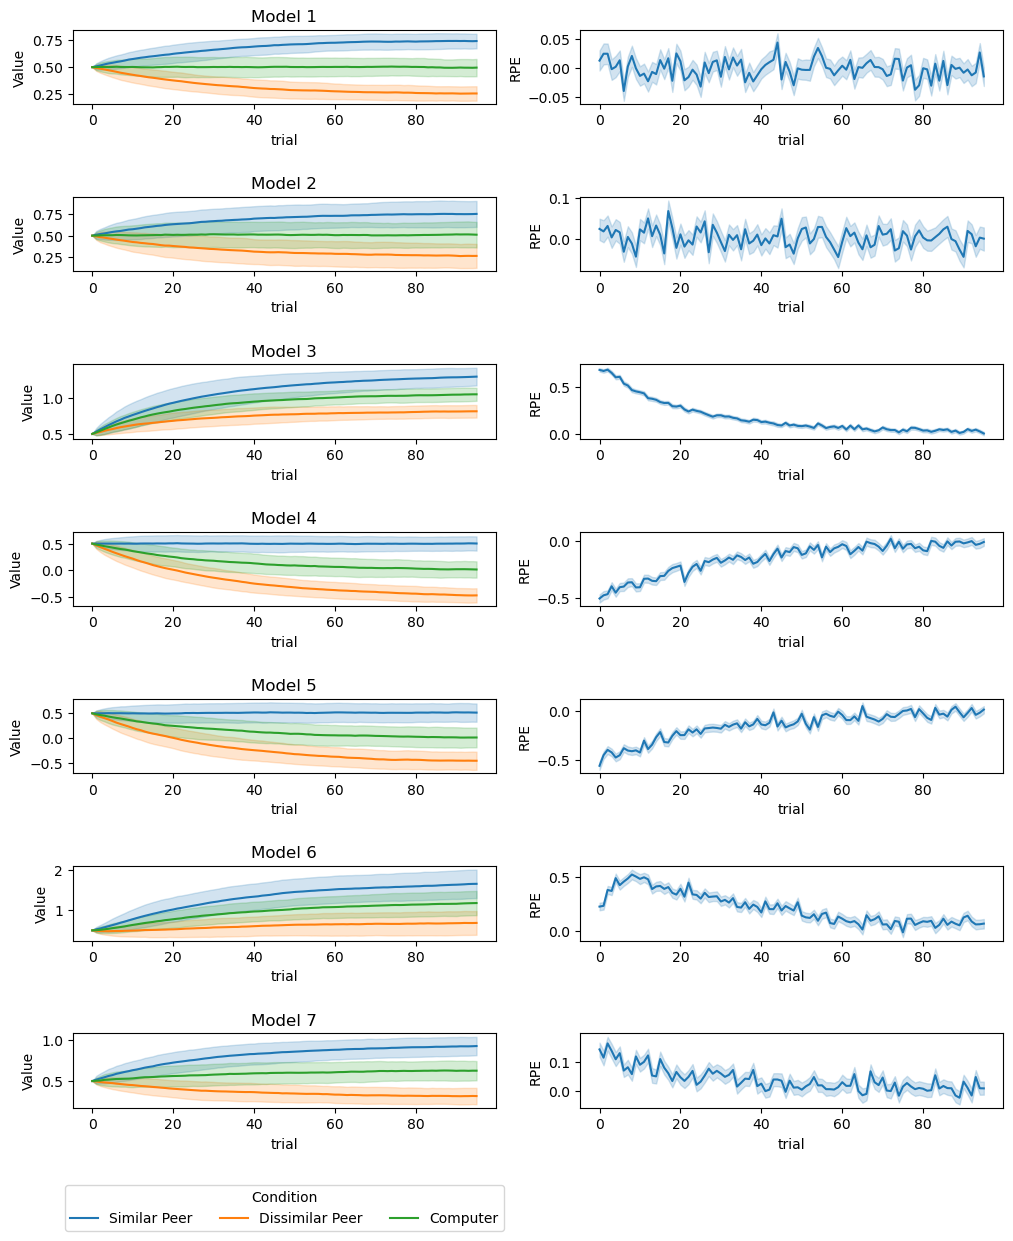

In [369]:
relv_models = [model_1_long, model_2_long, model_3_long, 
               model_4_long, model_5_long, model_6_long,
               model_7_long]

fig, axs = plt.subplots(len(relv_models),2, figsize=(12,2*len(relv_models)))
plt.subplots_adjust(wspace=0.2, hspace=1.25)

for i in range(len(relv_models)):
    sns.lineplot(data=relv_models[i], x='trial', y='Value', dashes=False, 
                 hue='Condition', errorbar='sd', ax=axs[i,0])
    ax1.set_ylabel('Condition Value')
    if i == len(relv_models)-1:
        sns.move_legend(axs[i,0], "lower center", bbox_to_anchor=(0.5, -1.75), 
                   labels=['Similar Peer','Dissimilar Peer','Computer'], ncol=3)
    else:
        axs[i,0].get_legend().remove()

    axs[i,0].set_title('Model '+str(i+1))
    
    sns.lineplot(data=relv_models[i], x='trial', y='RPE', dashes=False, ax=axs[i,1])
    ax2.set_ylabel('Reward Prediction Error')
    

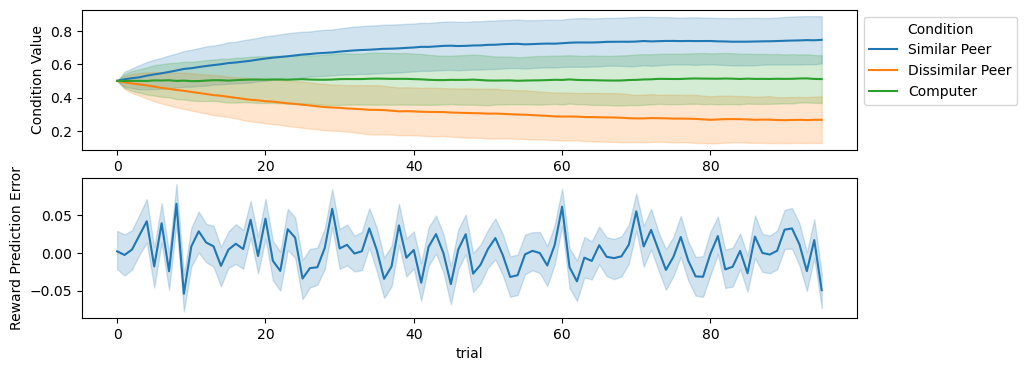

In [279]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4))

sns.lineplot(data=model_2_long, x='trial', y='Value', dashes=False, 
             hue='Condition', errorbar='sd', ax=ax1)
ax1.set_ylabel('Condition Value')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1,1), labels=['Similar Peer','Dissimilar Peer', 'Computer'])

sns.lineplot(data=model_2_long, x='trial', y='RPE', dashes=False, ax=ax2)
ax2.set_ylabel('Reward Prediction Error')

plt.subplots_adjust(wspace=0.8)

# Single Subject Analysis

In [5]:
subj = 'SCN_101'

# Find data for all runs
run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))
run_files.sort()
run_files

['/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run1-errors.csv',
 '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run2-errors.csv',
 '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run3-errors.csv',
 '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run4-errors.csv']

In [6]:
all_run_data = pd.DataFrame()

for file in run_files:
    if 'original' in file:
        continue
    temp_run = pd.read_csv(file, index_col=0)
    all_run_data = pd.concat([all_run_data, temp_run], ignore_index=True)

# Create column for peer info
all_run_data['Peer'] = [x.split('_')[1] for x in all_run_data['ConditionName']]

# Create feedback column of 1s and 0s for thumbs up and thumbs down, respectively
all_run_data['Feedback'] = [x.split('_')[0] for x in all_run_data['ConditionName']]
all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])

# Mark missed response trials with NaN for the feedback (because no feedback was given)
all_run_data.loc[all_run_data['Correct_RT'].isna(), 'Feedback'] = np.nan


all_run_data.head()

/var/folders/85/t_6qbb0j2pvbbd0sq3zrwbc00000gq/T/ipykernel_5759/156246036.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])


,ParticipantID,Run,Condition,ConditionName,Question,QuestionNumber,peerName,left_or_right,FirstButtonPressTime,CorrectButtonPressTime,...,FixDur,FixEnd,item_x,valence,item_y,rating,valence_redcap,redcap_v_task,Peer,Feedback
0,SCN_101,1,2,LowReward_SimPeer,like non-fiction,19.0,Shiloh,R,9.210867,9.210867,...,5.000847,5.017456,like non-fiction,pos,19,5,pos,0,SimPeer,0.0
1,SCN_101,1,0,LowReward_DisPeer,like yard sales,78.0,Charlie,R,19.992227,19.992227,...,NaN,NaN,like yard sales,pos,78,5,pos,0,DisPeer,0.0
2,SCN_101,1,5,HighReward_SimPeer,like laser tag,91.0,Shiloh,L,30.790777,30.790777,...,NaN,NaN,like laser tag,pos,91,5,pos,0,SimPeer,1.0
3,SCN_101,1,0,LowReward_DisPeer,like cooking,122.0,Charlie,L,43.877158,43.877158,...,NaN,NaN,like cooking,pos,122,5,pos,0,DisPeer,0.0
4,SCN_101,1,0,LowReward_DisPeer,don't play video games,209.0,Charlie,R,57.538735,57.538735,...,NaN,NaN,don't play video games,neg,209,2,neg,0,DisPeer,0.0


In [31]:
all_run_data[all_run_data['ConditionName'] == 'SimPeer']

,ParticipantID,Run,Condition,ConditionName,Question,QuestionNumber,peerName,left_or_right,FirstButtonPressTime,CorrectButtonPressTime,...,item_x,valence,item_y,rating,valence_redcap,redcap_v_task,Peer,Feedback,Value,RPE


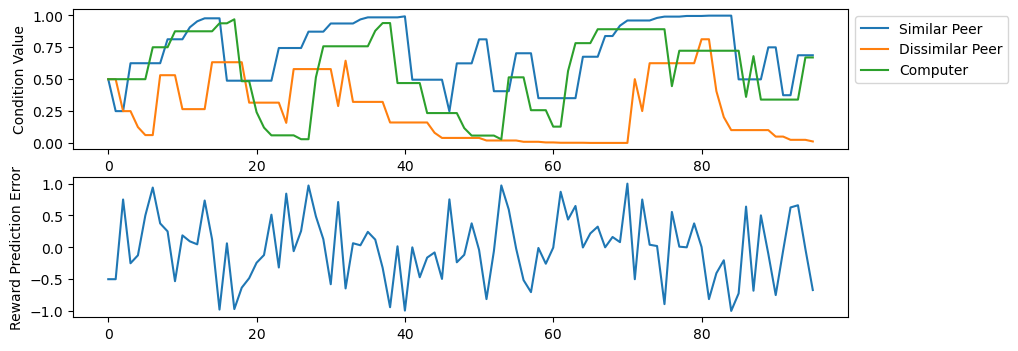

In [7]:
rl_output, all_run_data_rl = rl_model(all_run_data, alpha=0.5)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4))

sns.lineplot(rl_output[['SimPeer', 'DisPeer', 'Computer']], dashes=False, ax=ax1)
ax1.set_ylabel('Condition Value')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1,1), labels=['Similar Peer','Dissimilar Peer', 'Computer'])

sns.lineplot(rl_output['RPE'], dashes=False, ax=ax2)
ax2.set_ylabel('Reward Prediction Error')

plt.subplots_adjust(wspace=0.8)

# All Subjects

In [12]:
for subj in subj_list:
    subj_outp_dir = os.path.join(outp_dir, subj)
    if not os.path.exists(subj_outp_dir):
        os.makedirs(subj_outp_dir)
    
    run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))
    run_files.sort()
    
    if len(run_files) == 0:
        continue
    
    
    all_run_data = pd.DataFrame()

    for file in run_files:
        if 'original' in file:
            run_files.remove(file)
            continue
        temp_run = pd.read_csv(file, index_col=0)
        all_run_data = pd.concat([all_run_data, temp_run], ignore_index=True)

    # Create column for peer info
    all_run_data['Peer'] = [x.split('_')[1] for x in all_run_data['ConditionName']]

    # Create feedback column of 1s and 0s for thumbs up and thumbs down, respectively
    all_run_data['Feedback'] = [x.split('_')[0] for x in all_run_data['ConditionName']]
    all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])

    # Mark missed response trials with NaN for the feedback (because no feedback was given)
    all_run_data.loc[all_run_data['Correct_RT'].isna(), 'Feedback'] = np.nan
    
    
    rl_output, all_run_data_rl = rl_model(all_run_data, alpha=0.5)
    rl_output.to_csv(os.path.join(subj_outp_dir, 'rl_output-all_runs.csv'), index=False)
    
    for file in run_files:
        run_str = file.split('Run')[1][0]
        temp_run_data = all_run_data_rl[all_run_data_rl['Run'] == int(run_str)]
        temp_file_name = file.split('/')[-1]
        temp_run_data.to_csv(os.path.join(subj_outp_dir, temp_file_name), index=False)